# Análise Quantitativa do Impacto do Preço:

Qual o impacto na demanda e na receita se o preço aumentar ou diminuir?

Utilizando dados do estudo anterior, "pricing sensitivity", tentarei responder essa pergunta.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

Importando dados criados anteriormente:

In [13]:
df = pd.read_excel("../data/online_retail_no_outliers.xlsx")

product_df = pd.read_excel("../data/online_retail_product.xlsx")

In [20]:
product_df = pd.read_excel("../data/online_retail_product.xlsx")

product_df.head()

,stock_code_cleaned,avg_price,total_quantity,total_revenue,transactions
0,10002,0.850000,823,699.55,49
1,10080,0.411905,291,114.41,21
2,10120,0.210000,193,40.53,29
3,10123,0.650000,5,3.25,3
4,10124,0.420000,33,13.86,7


# Elasticidade:

Seguindo o mesmo modelo log-log para a elasticidade utilizado anteriormente:

>$\log{Q} = \alpha + \beta \log{P}$
>
>onde Q é a demanda e P o preço.
>
>O valor de $\beta$ é exatamente a elasticidade.

Irei armazenar as valores em 'product_df'.

In [26]:
elasticities = []

for product, data in df.groupby("stock_code_cleaned"):

    if data["unit_price_cleaned"].nunique() < 3:
        continue

    grouped = (
        data.groupby("unit_price_cleaned")["quantity_cleaned"]
        .sum()
        .reset_index()
    )

    grouped["log_price"] = np.log(grouped["unit_price_cleaned"])
    grouped["log_quantity"] = np.log(grouped["quantity_cleaned"])

    model = LinearRegression().fit(
        grouped[["log_price"]],
        grouped["log_quantity"]
    )

    elasticities.append({
        "stock_code_cleaned": product,
        "elasticity": model.coef_[0]
    })

elasticity_df = pd.DataFrame(elasticities)
elasticity_df.head()

,stock_code_cleaned,elasticity
0,10135,0.155150
1,11001,-3.687880
2,15036,4.464883
3,15044,-7.051606
4,15056,-0.763907


In [27]:
elasticity_df = elasticity_df.merge(
    product_df,
    on="stock_code_cleaned",
    how="left"
)

elasticity_df.head()


,stock_code_cleaned,elasticity,avg_price,total_quantity,total_revenue,transactions
0,10135,0.155150,1.197686,1938,1786.69,117
1,11001,-3.687880,1.851875,1252,1953.00,62
2,15036,4.464883,0.805015,21876,16044.44,324
3,15044,-7.051606,2.968779,1637,4632.07,139
4,15056,-0.763907,5.888074,7374,40169.54,548


# Cenários de variação de preço:

Irei analisar o efeito das variações de 20% a -20% no preço de todos os produtos

In [50]:
price_changes = [-0.20, -0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15, 0.20]

# Simulando o impacto:

Função de simulação:

In [51]:
def simular_impacto(row, price_change):
    new_price = row["avg_price"] * (1 + price_change)

    quantity_change = row["elasticity"] * price_change
    new_quantity = row["total_quantity"] * (1 + quantity_change)

    new_revenue = new_price * new_quantity

    return pd.Series({
        "new_price": new_price,
        "new_quantity": new_quantity,
        "new_revenue": new_revenue
    })

Rodar os cenários:

In [52]:
simulation_results = []

for change in price_changes:
    temp = elasticity_df.copy()

    simulated = temp.apply(
        simular_impacto,
        axis=1,
        price_change=change
    )

    temp = pd.concat([temp, simulated], axis=1)
    temp["price_change_%"] = int(change * 100)

    simulation_results.append(temp)

scenario_df = pd.concat(simulation_results)

Impacto agregado:

In [53]:
impact_df = (
    scenario_df
    .groupby("price_change_%")
    .agg(
        Total_Revenue=("new_revenue", "sum"),
        Total_Quantity=("new_quantity", "sum")
    )
    .reset_index()
)

impact_df.head()

,price_change_%,Total_Revenue,Total_Quantity
0,-20,9.581528e+06,5.938345e+06
1,-15,9.054428e+06,5.309211e+06
2,-10,8.394864e+06,4.680076e+06
3,-5,7.602835e+06,4.050942e+06
4,0,6.678343e+06,3.421808e+06


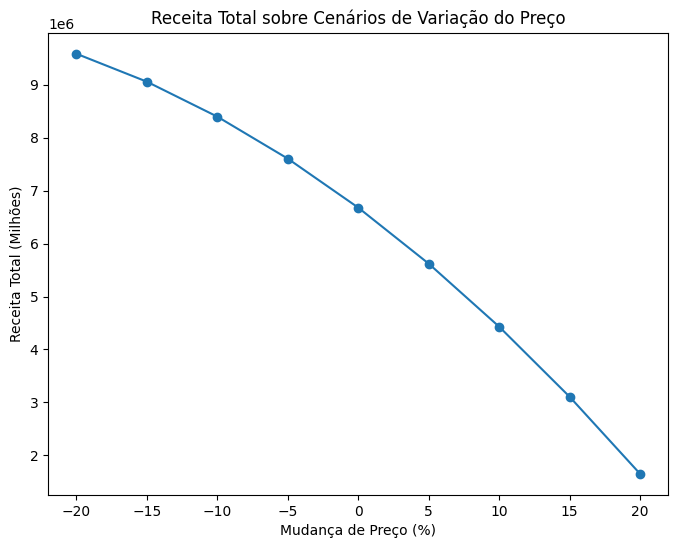

In [56]:
plt.figure(figsize=(8,6))
plt.plot(
    impact_df["price_change_%"],
    impact_df["Total_Revenue"],
    marker="o"
)
plt.xlabel("Mudança de Preço (%)")
plt.ylabel("Receita Total (Milhões)")
plt.title("Receita Total sobre Cenários de Variação do Preço")
plt.show()

A análise mostra um declínio na receita com o aumento do preço, e um aumento considerável na receita com a diminuição do preço.

# Conclusão:

O objetivo principal deste e de outros notebooks é demonstrar para os recrutadores minhas habilidades em análise de dados e tomada de decisões. Portanto, as análises feitas até agora devem ser ponderadas com cautela, pois possuem diversas limitações como:

- ***Premissa da elasticidade constante do Modelo log-log:***
    - Na realidade, a elasticidade costuma variar.
- ***Omissão de váriáveis relevantes:***
    - Não foram considerados sazonalidade, marketing, preços de concorrentes e mudanças macroenômicas nas análises até agora.
- ***Viés de Seleção:***
    - Remover produtos que tiveram menos de 2 variações no preço das análises.
- ***Causalidades:***
    - Até agora, a hipótese é de que preço causa demanda (o que não é correto).
- ***Independência entre produtos:***
    - A oferta de alguns produtos podem afetar a demanda de outros.

Portanto, embora a análise forneça uma direção estratégica sobre quais produtos possuem maior sensibilidade a preço, os resultados devem ser interpretados com cautela.